Import all necessary libraries

In [4]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random
import numpy as np
import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import requests

Load Google credentials to access files

In [5]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

base_url = f'https://drive.google.com/uc?id='

ind_hitter_file = '1HIme4Pn6KExguP_g-V34bx6an551R0ix'
ind_pitcher_file = '1Bj8vBOPDaeCQ1TKxv2VAAokzaN28Djok'
generic_hitter_file = '1CEU_mcCv0-uhDkPAmon0G1toP7L56UDL'
re288_file = '18ep4LTdmCO3B0YqzyZZjId_WS1IC5xth'
model_data_file = '14Ke69xnTpJipTFEYUlKjQBrLU4dpjNTZ'
model_file = '1bSvzmWKchYhJ6GqQFFcxps_4p3qQNCKI'

Load in all necessary files and apply proper data formatting

In [30]:
# Retrieve the model file from the base URL and load it using pickle
response = requests.get(base_url + model_file)
model = pickle.load(io.BytesIO(response.content))

# Download a file from Google Drive using its ID and save it as 'model_data.csv' -- this is the only one read this way because it is too big for the traditional read_csv method
downloaded = drive.CreateFile({'id': model_data_file})
downloaded.GetContentFile('model_data.csv')
model_data = pd.read_csv('model_data.csv')

# Separate outs, balls, and strikes
model_data['outs'] = model_data['out_base_count_state'].apply(lambda x: int(x.split('_')[0]))
model_data['balls'] = model_data['out_base_count_state'].apply(lambda x: int(x.split('_')[2][0]))
model_data['strikes'] = model_data['out_base_count_state'].apply(lambda x: int(x.split('_')[2][1]))

# Reset the index of the dataframe and drop the old index
model_data.reset_index(drop=True, inplace=True)

# Load additional data for individual pitchers and hitters and generic hitters from respective CSV files
ind_pitcher_sum = pd.read_csv(base_url + ind_pitcher_file)
ind_hitter_sum = pd.read_csv(base_url + ind_hitter_file)
generic_hitter_sum = pd.read_csv(base_url + generic_hitter_file)

# Load and process 'runs_expected' data based on 'out_base_count_state'
re288_df = pd.read_csv(base_url + re288_file)
re288 = re288_df.set_index('out_base_count_state')['runs_expected'].to_dict()

# Create a dictionary for pitcher data
pitcher_dict = {}
for _, row in ind_pitcher_sum.iterrows():
    pitcher = row['pitcher']
    p_throws = row['p_throws']
    pitch_type = row['pitch_type_condensed']

    # Initialize nested dictionaries if keys are not already present
    if pitcher not in pitcher_dict:
        pitcher_dict[pitcher] = {}
    if p_throws not in pitcher_dict[pitcher]:
        pitcher_dict[pitcher][p_throws] = {}

    # Store the row data in the dictionary under relevant keys
    pitcher_dict[pitcher][p_throws][pitch_type] = row.drop(['pitcher', 'p_throws', 'pitch_type_condensed']).to_dict()

# Create a dictionary for batter data
batter_dict = {}
for _, row in ind_hitter_sum.iterrows():
    batter = row['batter']
    p_throws = row['p_throws']
    stand = row['stand']
    pitch_type = row['pitch_type_condensed']

    # Initialize nested dictionaries if keys are not already present
    if batter not in batter_dict:
        batter_dict[batter] = {}
    if p_throws not in batter_dict[batter]:
        batter_dict[batter][p_throws] = {}
    if stand not in batter_dict[batter][p_throws]:
        batter_dict[batter][p_throws][stand] = {}

    # Store the row data in the dictionary under relevant keys
    batter_dict[batter][p_throws][stand][pitch_type] = row.drop(['batter', 'p_throws', 'stand', 'pitch_type_condensed']).to_dict()

# Create a dictionary for generic batter data
generic_batter_dict = {}
for _, row in generic_hitter_sum.iterrows():
    pitch_type = row['pitch_type_condensed']
    stand = row['stand']
    p_throws = row['p_throws']

    # Initialize nested dictionaries if keys are not already present
    if pitch_type not in generic_batter_dict:
        generic_batter_dict[pitch_type] = {}
    if stand not in generic_batter_dict[pitch_type]:
        generic_batter_dict[pitch_type][stand] = {}

    # Store the row data in the dictionary under relevant keys
    generic_batter_dict[pitch_type][stand][p_throws] = row.drop(['pitch_type_condensed', 'stand', 'p_throws']).to_dict()


GameState class that represents the state of an inning

In [31]:
class GameState:
    # Constructor for GameState class
    def __init__(self, outs=0, balls=0, strikes=0, runners={1: False, 2: False, 3: False}, runs=0, batting_order=None, current_batter_index=0, pitcher=None):
        # Initialize the state of the game
        self.outs = outs  # Number of outs in the current inning
        self.balls = balls  # Number of balls in the current count
        self.strikes = strikes  # Number of strikes in the current count
        self.runners = runners  # Dictionary representing runners on base (1st, 2nd, 3rd)
        self.runs = runs  # Total runs scored
        self.batting_order = batting_order if batting_order is not None else []  # Batting order list
        self.current_batter_index = current_batter_index  # Index of the current batter in the batting order
        self.pitcher = pitcher  # Current pitcher

    # Method to create a copy of the current game state
    def copy(self):
        # Returns a new instance of GameState with the same attributes
        return GameState(self.outs, self.balls, self.strikes, self.runners.copy(), self.runs, self.batting_order.copy(), self.current_batter_index, self.pitcher)

    # Method to generate a code string representing the current game state
    def to_code(self):
        # Create a string representing the runners on base
        runners_code = ''.join(['1' if self.runners[base] else '0' for base in [1, 2, 3]])
        # Return a formatted string combining outs, runners code, balls, and strikes
        return f"{self.outs}_{runners_code}_{self.balls}{self.strikes}"

    # Method to update the index to the next batter in the batting order
    def next_batter(self):
        # Increment current batter index and loop back if it reaches the end of the batting order
        self.current_batter_index = (self.current_batter_index + 1) % len(self.batting_order)

    # Static method to update the runners and runs based on the game event
    def update_runners_runs(runners, runs, advancement, force=False):

        # Handles forced runner advancement and scoring (instances of HBP or walk)
        if force:
            if runners[1] and runners[2] and runners[3]:
                new_runners = {1: True, 2: True, 3: True}
                runs += 1
            elif runners[1] and runners[2]:
                new_runners = {1: True, 2: True, 3: True}
            elif runners[1]:
                new_runners = {1: True, 2: True, 3: False}
            else:
                new_runners = runners
                new_runners[1] = True
            return new_runners, runs

        # General runner advancement logic
        new_runners = {1: False, 2: False, 3: False}

        # put the runner who just hit on base
        if advancement < 4:
            new_runners[advancement] = True
        else: # unless they hit a home run (advancement = 4)
            runs += 1

        # advance every runner on base by 'advancement' bases
        for key in runners:
            if runners[key]:
                if key + advancement < 4: # if they haven't scored, put them on the right base
                    new_runners[key + advancement] = True
                else: # if they have increment the runs
                    runs += 1

        return new_runners, runs

    # Method to update the state of the game based on a game event (e.g., ball, strike, hit)
    def update_state(self, event):

        # Create a deep copy of the current state to update
        new_state = copy.deepcopy(self)

        # if the ball does not end the at bat just increment balls, otherwise reset the count, update the runners, and move to the next batter
        if event == "ball":

            if self.balls < 3:
                new_state.balls += 1
            else:
                new_state.balls = 0
                new_state.strikes = 0
                new_state.runners, new_state.runs = GameState.update_runners_runs(self.runners, self.runs, 1, force=True)
                new_state.next_batter()

        # if the strikes does not end the at bat just increment strikes, otherwise increment outs, reset the count, and move to the next batter
        elif event == "strike":

            if self.strikes < 2:
                new_state.strikes += 1
            else:
                new_state.outs += 1
                new_state.balls = 0
                new_state.strikes = 0
                new_state.next_batter()

        # if the foul is before 2 strikes, increment strikes, otherwise nothing happens
        elif event == "foul":

            if self.strikes < 2:
                new_state.strikes += 1

        # if the batter was hit by pitch, move the runners, reset, the count, and move to the next batter
        elif event == "hit_by_pitch":

            new_state.runners, new_state.runs = GameState.update_runners_runs(self.runners, self.runs, 1, force=True)
            new_state.balls = 0
            new_state.strikes = 0
            new_state.next_batter()

        # if the batter got out, increment the outs, reset the count, and move to the next batter
        # for simplicity purposes assume outs occur only one at a time (no double or triple play), always occur to the batter (no runners on base are removed), and no runners move bases on outs
        elif event == "out":

            new_state.outs += 1
            new_state.balls = 0
            new_state.strikes = 0
            new_state.next_batter()

        # if the batter got a hit, move the runners, reset the count, and move to the next batter
        # for simplicity purposes, assume each hit type advances runners exactly how many bases the batter advanced (single = 1, double = 2, triple = 3, home run = 4)

        elif event == "single":

            new_state.runners, new_state.runs = GameState.update_runners_runs(self.runners, self.runs, 1)
            new_state.balls = 0
            new_state.strikes = 0
            new_state.next_batter()
        elif event == "double":

            new_state.runners, new_state.runs = GameState.update_runners_runs(self.runners, self.runs, 2)
            new_state.balls = 0
            new_state.strikes = 0
            new_state.next_batter()
        elif event == "triple":

            new_state.runners, new_state.runs = GameState.update_runners_runs(self.runners, self.runs, 3)
            new_state.balls = 0
            new_state.strikes = 0
            new_state.next_batter()
        elif event == "home_run":

            new_state.runners, new_state.runs = GameState.update_runners_runs(self.runners, self.runs, 4)
            new_state.balls = 0
            new_state.strikes = 0
            new_state.next_batter()

        return new_state

    # Method to get the current batter based on the batting order and current index
    def get_current_batter(self):
        # Return the current batter from the batting order
        return self.batting_order[self.current_batter_index]

    # Special method to return a string representation of the current game state
    def __str__(self):
        # Return a formatted string showing various elements of the game state
        return f"Pitcher {self.pitcher} v Batter {self.batting_order[self.current_batter_index]}\n  Outs: {self.outs}\n  Count: {self.balls}-{self.strikes}\n  Runners: {self.runners}\n  Runs: {self.runs}"

In [32]:
def generate_prediction_dictionary(pitcher_hand, batter, pitch_type, game_state, pitch_types_dict):
    # Initialize prediction dictionary
    prediction_dictionary = {}

    # For pitch movement metrics, assume some variance from pitcher's average using their standard deviation and mean over the season
    prediction_dictionary['release_speed'] = np.random.normal(pitch_types_dict[pitch_type]['avgVelo'], pitch_types_dict[pitch_type]['sdVelo'])
    prediction_dictionary['release_pos_x'] = np.random.normal(pitch_types_dict[pitch_type]['avgRPX'], pitch_types_dict[pitch_type]['sdRPX'])
    prediction_dictionary['release_pos_y'] = np.random.normal(pitch_types_dict[pitch_type]['avgRPY'], pitch_types_dict[pitch_type]['sdRPY'])
    prediction_dictionary['release_pos_z'] = np.random.normal(pitch_types_dict[pitch_type]['avgRPZ'], pitch_types_dict[pitch_type]['sdRPZ'])
    prediction_dictionary['pfx_x'] = np.random.normal(pitch_types_dict[pitch_type]['avgHBRK'], pitch_types_dict[pitch_type]['sdHBRK'])
    prediction_dictionary['pfx_z'] = np.random.normal(pitch_types_dict[pitch_type]['avgVBRK'], pitch_types_dict[pitch_type]['sdVBRK'])

    # Add in game state details
    prediction_dictionary['outs'] = game_state.outs
    prediction_dictionary['balls'] = game_state.balls
    prediction_dictionary['strikes'] = game_state.strikes

    # Format categorical variable
    if pitcher_hand == "R":
        prediction_dictionary['p_throws_R'] = 1
        prediction_dictionary['p_throws_L'] = 0
    else:
        prediction_dictionary['p_throws_R'] = 1
        prediction_dictionary['p_throws_L'] = 0

    # If a batter has sufficient sample size vs pitcher of same hand and pitch type, populate prediction dictionary with their specific data
    if pitcher_hand in batter_dict[batter]:
        stand = list(batter_dict[batter][pitcher_hand].keys())[0]
        if pitch_type in batter_dict[batter][pitcher_hand][stand].keys():
            rel_dict = batter_dict[batter][pitcher_hand][stand][pitch_type]
            prediction_dictionary['sz_bot'] = rel_dict['sz_bot'] # bottom of strikzone for hitter
            prediction_dictionary['sz_top'] = rel_dict['sz_top'] # top of strikezone for hitter
            prediction_dictionary['avgEV'] = rel_dict['avgEV'] # average exit velocity (how hard they hit the ball)
            prediction_dictionary['avgLA'] = rel_dict['avgLA'] # average launch angle (degree of launch they hit the ball)
            prediction_dictionary['zSwingPCT'] = rel_dict['zSwingPCT'] # percentage of pitches in the strikezone they swing at
            prediction_dictionary['oSwingPCT'] = rel_dict['oSwingPCT'] # percentage of pitches outside the strikezone they swing at
    else:
        stand = 'R'

    # If a batter does not have sufficient sample size vs pitcher of same hand and pitch type, populate prediction dictionary with general hitter data vs that hand and pitch type
    if 'sz_bot' not in prediction_dictionary:
        rel_dict = generic_batter_dict[pitch_type][stand][pitcher_hand]
        prediction_dictionary['sz_bot'] = rel_dict['sz_bot']
        prediction_dictionary['sz_top'] = rel_dict['sz_top']
        prediction_dictionary['avgEV'] = rel_dict['avgEV']
        prediction_dictionary['avgLA'] = rel_dict['avgLA']
        prediction_dictionary['zSwingPCT'] = rel_dict['zSwingPCT']
        prediction_dictionary['oSwingPCT'] = rel_dict['oSwingPCT']

    # Format categorical variables
    if stand == "R":
        prediction_dictionary['stand_R'] = 1
        prediction_dictionary['stand_L'] = 0
    else:
        prediction_dictionary['stand_R'] = 0
        prediction_dictionary['stand_L'] = 1

    return prediction_dictionary

def calculate_sz_height_locs(pitch_type, sz_height_third, sz_height_mid):
    # Determins the locations a pitcher could throw vertically (vertical strikezone changes from hitter to hitter but horizontal remains the same)

    # Only allow FF and CT to be thrown at the top of the zone and above
    if pitch_type in ["FF", "CT"]:
        sz_height_locs = [sz_height_mid - 2*sz_height_third,
                    sz_height_mid - sz_height_third,
                    sz_height_mid,
                    sz_height_mid + sz_height_third,
                    sz_height_mid + 2*sz_height_third]
    else: # Don't allow sinkers or offspeed to be thrown at the top of the zone -- not a reasonable strategy
        sz_height_locs = [sz_height_mid - 2*sz_height_third,
                    sz_height_mid - sz_height_third,
                    sz_height_mid]

    return sz_height_locs

def predict_outcome_probabilities(features):

    # Convert prediction features to right data type
    if isinstance(features, dict):
        features = pd.DataFrame([features])
    elif isinstance(features, pd.Series):
        features = features.to_frame().transpose()

    # Order features correctly
    expected_feature_order = ['release_speed', 'release_pos_x', 'release_pos_y', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'sz_bot', 'sz_top', 'avgEV', 'avgLA', 'zSwingPCT', 'oSwingPCT', 'outs', 'balls', 'strikes', 'stand_L', 'stand_R', 'p_throws_L', 'p_throws_R']
    features = features[expected_feature_order]

    # Get probabilities of each event occuring
    probabilities = model.predict_proba(features)[0]
    category_names = model_data['events'].astype('category').cat.categories
    outcome_probabilities = {category_names[i]: prob for i, prob in enumerate(probabilities)}

    return outcome_probabilities

def calculate_exp_val(event_probs, cur_state):

    # Calculate the expected value of a pitch, loc_x, loc_z by summing the prob_occurrence*post_event_val
    exp_val = 0
    for event, prob in event_probs.items():
        new_state = cur_state.copy()
        new_state = new_state.update_state(event)
        if new_state.outs == 3:
            new_rv = 0
        else:
            new_rv = re288[new_state.to_code()]
        exp_val += new_rv*prob

    return exp_val

def simulate_action(best_prediction_dictionary):
    # based on the pitch, loc_x, loc_z that was chosen, simulate what happens by taking a weighted random choice
    event_probs = predict_outcome_probabilities(best_prediction_dictionary)
    events = list(event_probs.keys())
    probabilities = [event_probs[event] for event in events]
    chosen_event = random.choices(events, weights=probabilities, k=1)[0]
    return chosen_event

def plot_result(pred_dict, pitch, sz_bot, sz_top, sz_left, sz_right, event, game_state):
    # Plot the pitch location and type and print relevant information about the state of the game
    plt.figure(figsize=(4, 6))
    plt.scatter(pred_dict['plate_x'], pred_dict['plate_z'], label=pitch)

    plt.hlines(y=sz_bot, xmin=sz_left, xmax=sz_right, color='k', linestyle='-')
    plt.hlines(y=sz_top, xmin=sz_left, xmax=sz_right, color='k', linestyle='-')
    plt.vlines(x=sz_left, ymin=sz_bot, ymax=sz_top, color='k', linestyle='-')
    plt.vlines(x=sz_right, ymin=sz_bot, ymax=sz_top, color='k', linestyle='-')

    plt.title('Pitch Location and Type')
    plt.xlim(-1.3, 1.3)
    plt.ylim(0, 4.8)
    plt.legend()
    plt.show()
    print(f'Result: {event}')
    if game_state.outs < 3:
        print(game_state)
    else:
        print('INNING OVER\n\n\n\n')

def plot_inning(states, rvs, pitches, xs, zs, pitch_types):
    # Plot the expected runs scored for the inning over the course of pitches thrown
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(states)), rvs, marker='o')

    labels = ['0_000_00']

    for i in range(1, len(states)):
        labels.append(f'Pitch {i}: {pitches[i]}\n{states[i]}')

    plt.xticks(range(len(states)), labels, rotation=45, fontsize=8)

    pitch_types_str = ', '.join(pitch_types)

    plt.title(f'{pitcher} Inning Progression -- {len(states)-1} pitch inning\nArsenal: {pitch_types_str}')
    plt.xlabel('Pitch Number, Pitch Type, and Inning State')
    plt.ylabel('Expected Runs Rest of Inning')
    plt.grid(True)
    plt.ylim(0, 1.2*max(rvs))

    plt.show()

    print(f'\n')

    # Plot every pitch thrown in the inning by pitch type
    xs = xs[1:]
    zs = zs[1:]
    pitches = pitches[1:]

    sz_left = -9.97/12
    sz_right = 9.97/12
    sz_bot = 1.7
    sz_top = 3.5

    plt.figure(figsize=(5, 8))

    pitch_colors = {}
    unique_pitches = set(pitches)

    for i, pitch in enumerate(unique_pitches):
        pitch_colors[pitch] = plt.cm.viridis(i / len(unique_pitches))

    for x, z, pitch in zip(xs, zs, pitches):
        plt.scatter(x, z, color=pitch_colors[pitch], label=pitch)

    plt.hlines(y=sz_bot, xmin=sz_left, xmax=sz_right, color='k', linestyle='-')
    plt.hlines(y=sz_top, xmin=sz_left, xmax=sz_right, color='k', linestyle='-')
    plt.vlines(x=sz_left, ymin=sz_bot, ymax=sz_top, color='k', linestyle='-')
    plt.vlines(x=sz_right, ymin=sz_bot, ymax=sz_top, color='k', linestyle='-')

    plt.title('Inning Summary Pitch Locations')
    plt.xlim(-1.3, 1.3)
    plt.ylim(0, 4.8)

    handles = [plt.Line2D([0], [0], marker='o', color='w', label=pitch, markersize=10, markerfacecolor=color) for pitch, color in pitch_colors.items()]
    plt.legend(handles=handles, title="Pitch Types")

    plt.show()

Simulate an Inning -- every inning will select a random pitcher and 9 random batters

Pitcher: 621112 (R)
Pitches: ['CB', 'CH', 'CT', 'FF', 'SI', 'SL']





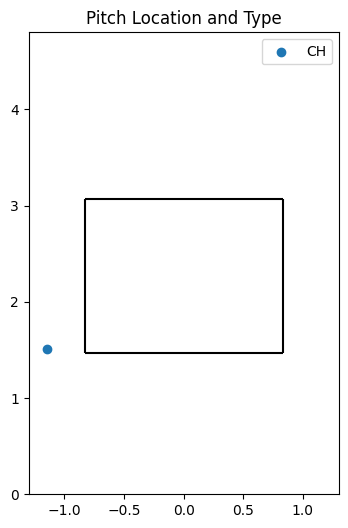

Result: ball
Pitcher 621112 v Batter 543257
  Outs: 0
  Count: 1-0
  Runners: {1: False, 2: False, 3: False}
  Runs: 0


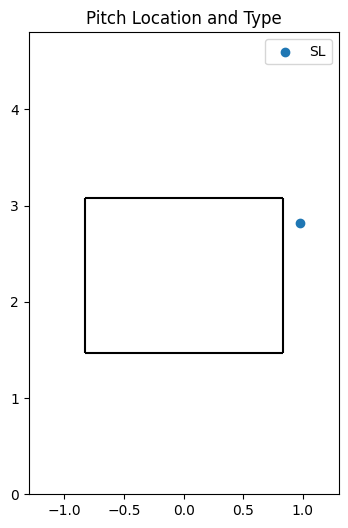

Result: foul
Pitcher 621112 v Batter 543257
  Outs: 0
  Count: 1-1
  Runners: {1: False, 2: False, 3: False}
  Runs: 0


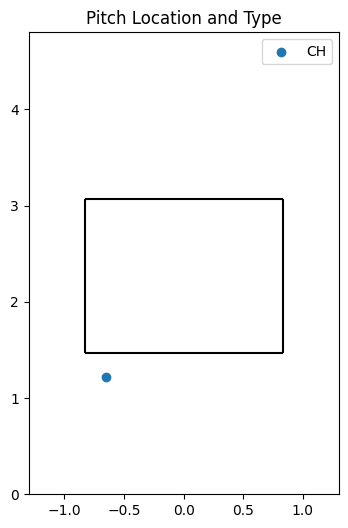

Result: single
Pitcher 621112 v Batter 606115
  Outs: 0
  Count: 0-0
  Runners: {1: True, 2: False, 3: False}
  Runs: 0


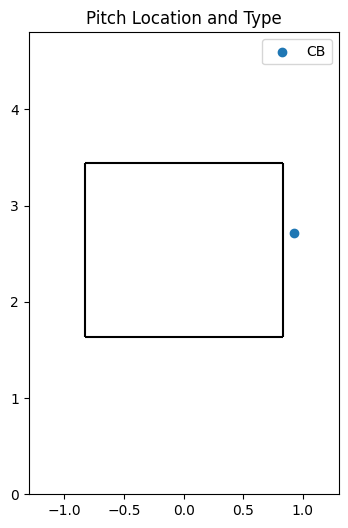

Result: ball
Pitcher 621112 v Batter 606115
  Outs: 0
  Count: 1-0
  Runners: {1: True, 2: False, 3: False}
  Runs: 0


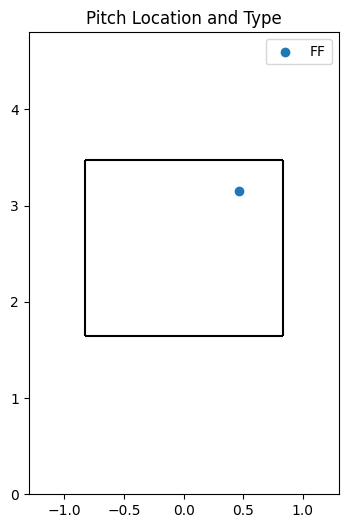

Result: foul
Pitcher 621112 v Batter 606115
  Outs: 0
  Count: 1-1
  Runners: {1: True, 2: False, 3: False}
  Runs: 0


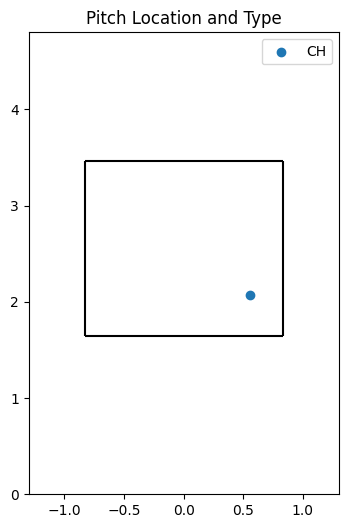

Result: out
Pitcher 621112 v Batter 595777
  Outs: 1
  Count: 0-0
  Runners: {1: True, 2: False, 3: False}
  Runs: 0


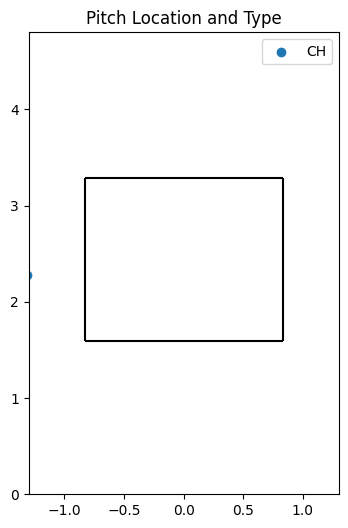

Result: ball
Pitcher 621112 v Batter 595777
  Outs: 1
  Count: 1-0
  Runners: {1: True, 2: False, 3: False}
  Runs: 0


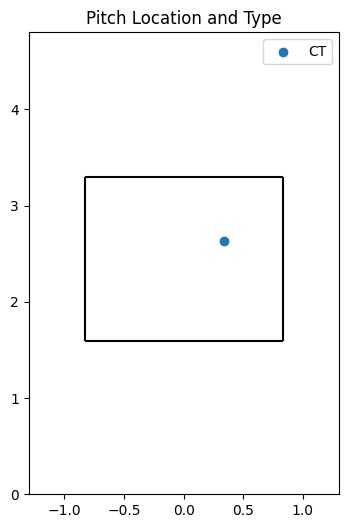

Result: foul
Pitcher 621112 v Batter 595777
  Outs: 1
  Count: 1-1
  Runners: {1: True, 2: False, 3: False}
  Runs: 0


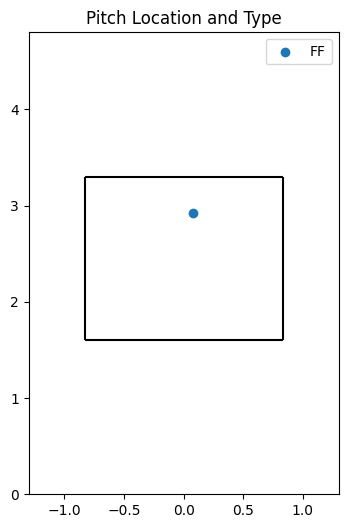

Result: foul
Pitcher 621112 v Batter 595777
  Outs: 1
  Count: 1-2
  Runners: {1: True, 2: False, 3: False}
  Runs: 0


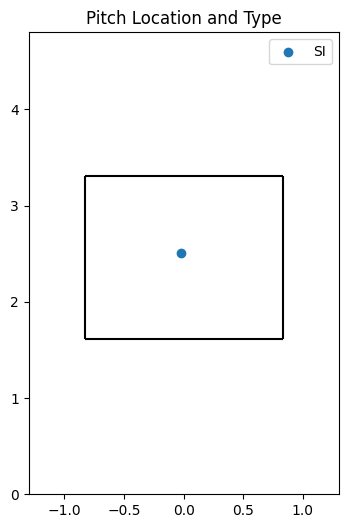

Result: strike
Pitcher 621112 v Batter 678662
  Outs: 2
  Count: 0-0
  Runners: {1: True, 2: False, 3: False}
  Runs: 0


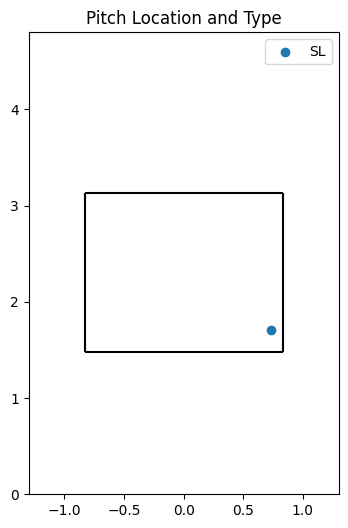

Result: out
INNING OVER






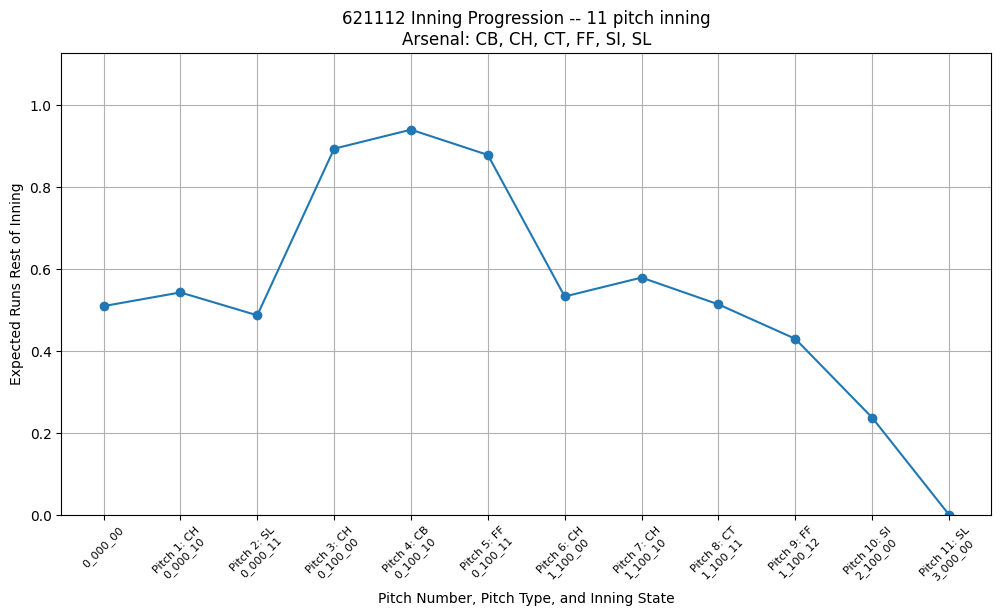

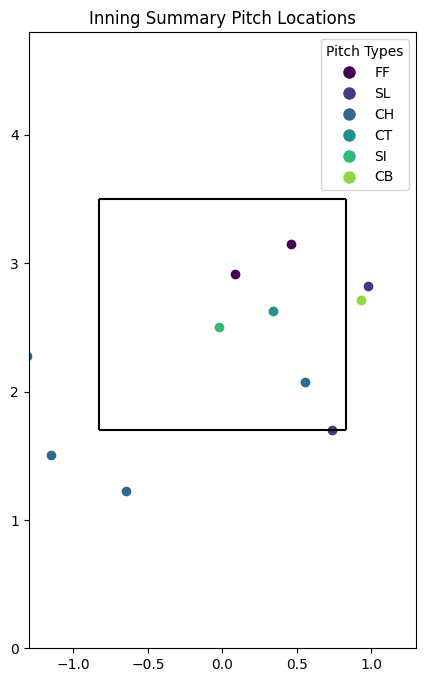

In [34]:
# Select a random pitcher from the pitcher dictionary
pitcher = random.sample(list(pitcher_dict.keys()), 1)[0]
# Select 9 random batters from the batter dictionary
batters = random.sample(list(batter_dict.keys()), 9)

# Determine the pitching hand of the chosen pitcher
pitcher_hand = list(pitcher_dict[pitcher].keys())[0]
# Get the list of pitch types that the chosen pitcher can throw
pitch_types = list(pitcher_dict[pitcher][pitcher_hand].keys())
# Dictionary containing detailed stats for each pitch type of the selected pitcher
pitch_types_dict = pitcher_dict[pitcher][pitcher_hand]

# Define dimensions of the strike zone's sides
sz_left = -9.97/12  # Left edge of the strike zone
sz_right = 9.97/12  # Right edge of the strike zone
sz_side_mid = (sz_left + sz_right) / 2  # Middle of the strike zone sides
sz_side_third = abs(sz_left - sz_right) / 3  # One third of the strike zone's width

# Calculate positions for potential pitch locations horizontally across the strike zone
sz_side_locs = [sz_side_mid - 2*sz_side_third,
                sz_side_mid - sz_side_third,
                sz_side_mid,
                sz_side_mid + sz_side_third,
                sz_side_mid + 2*sz_side_third]

# Standard deviations for random variations in pitch locations
x_miss_sd = 0.4  # Standard deviation for horizontal miss
z_miss_sd = 0.4  # Standard deviation for vertical miss

# Print information about the selected pitcher
print(f'Pitcher: {pitcher} ({pitcher_hand})\nPitches: {pitch_types}\n\n\n')

# Initialize the game state with the selected batters and pitcher
game_state = GameState(batting_order=batters, pitcher=pitcher)

# Initialize tracking variables for the game state, run values, pitches, and pitch locations
states = [game_state.to_code()]
rvs = [re288[game_state.to_code()]]
pitches = [None]
xs = [None]
zs = [None]

# Loop to simulate the game until there are 3 outs
while game_state.outs < 3:
    cur_state = game_state.copy()  # Copy the current game state

    # Get the current batter
    batter = game_state.batting_order[game_state.current_batter_index]

    # Initialize variable for tracking the best pitch
    min_rv = float('inf')
    for pitch_type in pitch_types:
        # Generate a prediction dictionary for the current pitch
        prediction_dictionary = generate_prediction_dictionary(pitcher_hand, batter, pitch_type, cur_state, pitch_types_dict)

        # Get strikezone height locations
        sz_bot = prediction_dictionary['sz_bot']
        sz_top = prediction_dictionary['sz_top']
        sz_height_third = abs(sz_top - sz_bot) / 3
        sz_height_mid = (sz_top + sz_bot) / 2
        sz_height_locs = calculate_sz_height_locs(pitch_type, sz_height_third, sz_height_mid)

        # Iterate over potential pitch locations and calculate the expected value for each
        for loc_x in sz_side_locs:
            for loc_z in sz_height_locs:
                prediction_dictionary['plate_x'] = loc_x
                prediction_dictionary['plate_z'] = loc_z

                # Calculate expected value of the pitch at this location
                exp_val = calculate_exp_val(predict_outcome_probabilities(prediction_dictionary), cur_state)

                # Update the best pitch if this one has a lower expected run value
                if exp_val < min_rv:
                    min_rv = exp_val
                    best_loc = (loc_x, loc_z)
                    best_pitch = pitch_type
                    best_prediction_dictionary = copy.deepcopy(prediction_dictionary)

    # Add something to factor in for the lack of perfect command in a pitcher, by accounting for variance in miss side and height
    best_prediction_dictionary['plate_x'] = np.random.normal(best_prediction_dictionary['plate_x'], x_miss_sd)
    best_prediction_dictionary['plate_z'] = np.random.normal(best_prediction_dictionary['plate_z'], z_miss_sd)
    xs.append(best_prediction_dictionary['plate_x'])
    zs.append(best_prediction_dictionary['plate_z'])

    # Simulate the outcome of the pitch
    event = simulate_action(best_prediction_dictionary)

    # Update the game state based on the event
    game_state = game_state.update_state(event)

    # Handle the end of the inning
    if game_state.outs == 3:
        states.append('3_000_00')
        rvs.append(game_state.runs)
        pitches.append(best_pitch)
        plot_result(best_prediction_dictionary, best_pitch, best_prediction_dictionary['sz_bot'], best_prediction_dictionary['sz_top'], sz_left, sz_right, event, game_state)
        continue

    states.append(game_state.to_code())
    rvs.append(re288[game_state.to_code()] + game_state.runs)
    pitches.append(best_pitch)
    plot_result(best_prediction_dictionary, best_pitch, best_prediction_dictionary['sz_bot'], best_prediction_dictionary['sz_top'], sz_left, sz_right, event, game_state)

# Plot a summary of the inning after all pitches
plot_inning(states, rvs, pitches, xs, zs, pitch_types)

Play yourself! Random pitcher and batters will be selected

Pitcher: 656629 (R)
Pitches: ['CB', 'CH', 'FF', 'SL']
Batters: 679529, 676914, 553993, 657757, 571912, 657656, 592450, 666139, 664023

The strikezone typically spans from (-0.9, 0.9) left to right and (1.7, 3.5) bottom to top


Enter the pitch you would like to throw (CB, CH, FF, SL): FF
Enter the x coordinate of this pitch: 0
Enter the z coordinate of this pitch: 4


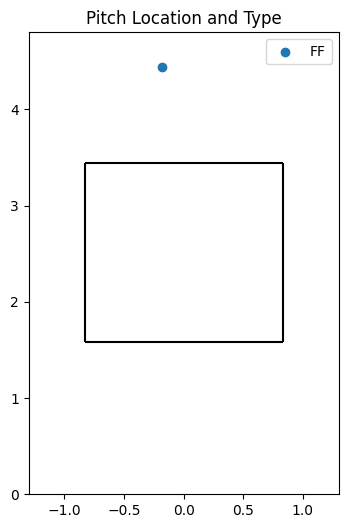

Result: ball
Pitcher 656629 v Batter 679529
  Outs: 0
  Count: 1-0
  Runners: {1: False, 2: False, 3: False}
  Runs: 0
Enter the pitch you would like to throw (CB, CH, FF, SL): SL
Enter the x coordinate of this pitch: -.5
Enter the z coordinate of this pitch: 2


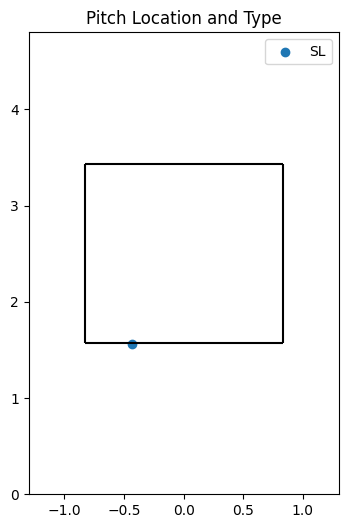

Result: foul
Pitcher 656629 v Batter 679529
  Outs: 0
  Count: 1-1
  Runners: {1: False, 2: False, 3: False}
  Runs: 0
Enter the pitch you would like to throw (CB, CH, FF, SL): CB
Enter the x coordinate of this pitch: 0
Enter the z coordinate of this pitch: 2


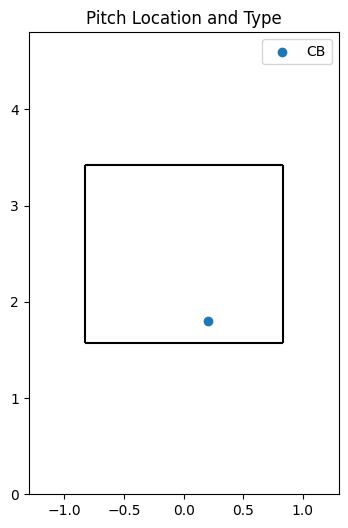

Result: foul
Pitcher 656629 v Batter 679529
  Outs: 0
  Count: 1-2
  Runners: {1: False, 2: False, 3: False}
  Runs: 0
Enter the pitch you would like to throw (CB, CH, FF, SL): FF
Enter the x coordinate of this pitch: 1
Enter the z coordinate of this pitch: 3.5


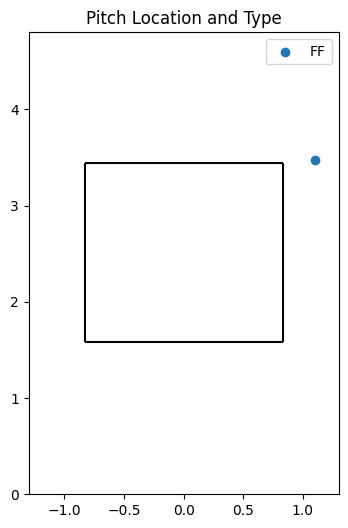

Result: ball
Pitcher 656629 v Batter 679529
  Outs: 0
  Count: 2-2
  Runners: {1: False, 2: False, 3: False}
  Runs: 0
Enter the pitch you would like to throw (CB, CH, FF, SL): SL
Enter the x coordinate of this pitch: -1
Enter the z coordinate of this pitch: 1.6


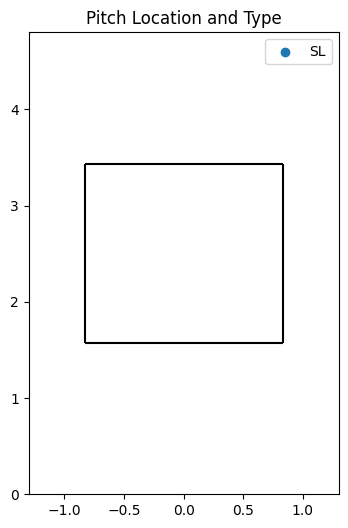

Result: ball
Pitcher 656629 v Batter 679529
  Outs: 0
  Count: 3-2
  Runners: {1: False, 2: False, 3: False}
  Runs: 0
Enter the pitch you would like to throw (CB, CH, FF, SL): .5
Invalid pitch type.
Enter the pitch you would like to throw (CB, CH, FF, SL): SL
Enter the x coordinate of this pitch: .5
Enter the z coordinate of this pitch: 1.7


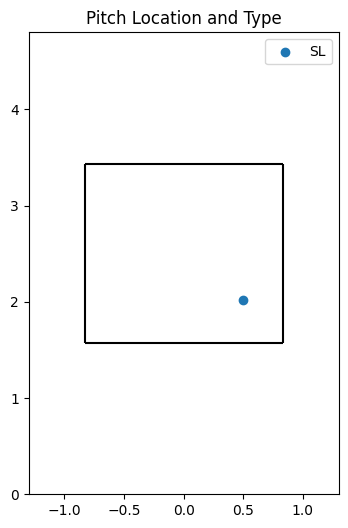

Result: strike
Pitcher 656629 v Batter 676914
  Outs: 1
  Count: 0-0
  Runners: {1: False, 2: False, 3: False}
  Runs: 0
Enter the pitch you would like to throw (CB, CH, FF, SL): FF
Enter the x coordinate of this pitch: -.7
Enter the z coordinate of this pitch: 1.7


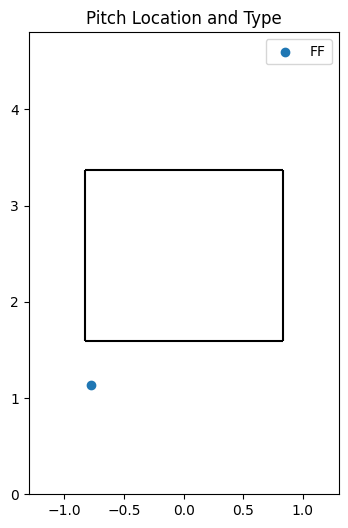

Result: foul
Pitcher 656629 v Batter 676914
  Outs: 1
  Count: 0-1
  Runners: {1: False, 2: False, 3: False}
  Runs: 0
Enter the pitch you would like to throw (CB, CH, FF, SL): CH
Enter the x coordinate of this pitch: 0.8
Enter the z coordinate of this pitch: 2


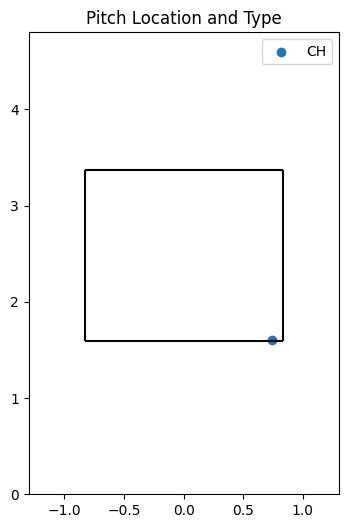

Result: strike
Pitcher 656629 v Batter 676914
  Outs: 1
  Count: 0-2
  Runners: {1: False, 2: False, 3: False}
  Runs: 0
Enter the pitch you would like to throw (CB, CH, FF, SL): FF
Enter the x coordinate of this pitch: 0
Enter the z coordinate of this pitch: 3.6


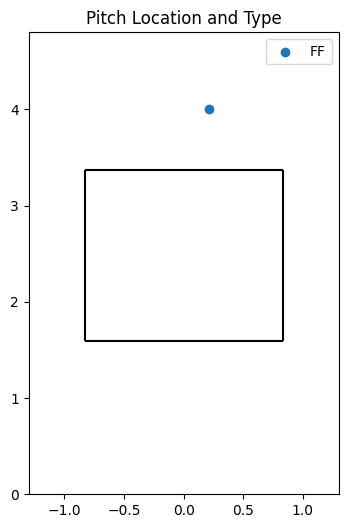

Result: ball
Pitcher 656629 v Batter 676914
  Outs: 1
  Count: 1-2
  Runners: {1: False, 2: False, 3: False}
  Runs: 0
Enter the pitch you would like to throw (CB, CH, FF, SL): CH
Enter the x coordinate of this pitch: 1.6
Enter the z coordinate of this pitch: 1


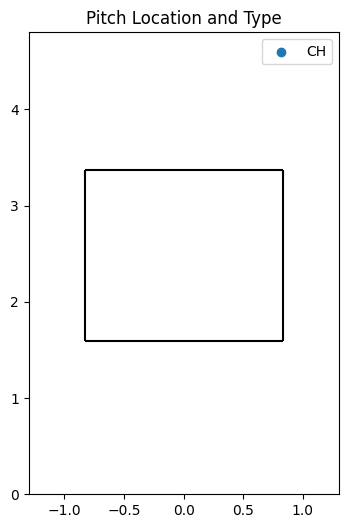

Result: ball
Pitcher 656629 v Batter 676914
  Outs: 1
  Count: 2-2
  Runners: {1: False, 2: False, 3: False}
  Runs: 0
Enter the pitch you would like to throw (CB, CH, FF, SL): CB
Enter the x coordinate of this pitch: 0
Enter the z coordinate of this pitch: 1.7


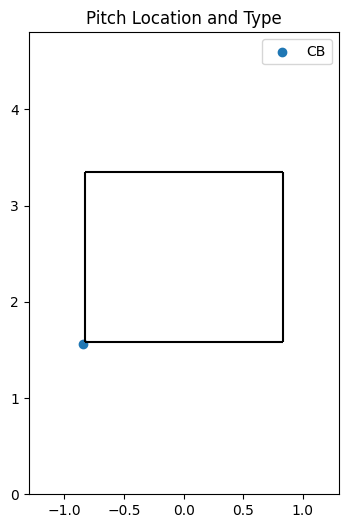

Result: ball
Pitcher 656629 v Batter 676914
  Outs: 1
  Count: 3-2
  Runners: {1: False, 2: False, 3: False}
  Runs: 0
Enter the pitch you would like to throw (CB, CH, FF, SL): FF
Enter the x coordinate of this pitch: 0
Enter the z coordinate of this pitch: 2


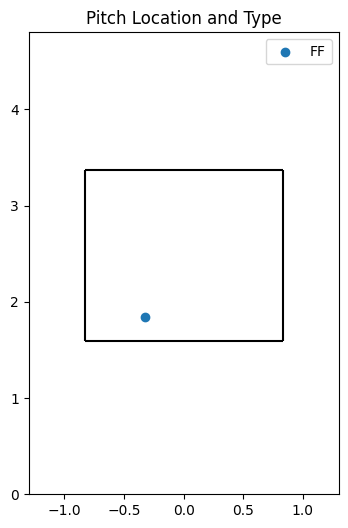

Result: single
Pitcher 656629 v Batter 553993
  Outs: 1
  Count: 0-0
  Runners: {1: True, 2: False, 3: False}
  Runs: 0
Enter the pitch you would like to throw (CB, CH, FF, SL): SL
Enter the x coordinate of this pitch: 0.8
Enter the z coordinate of this pitch: 2.5


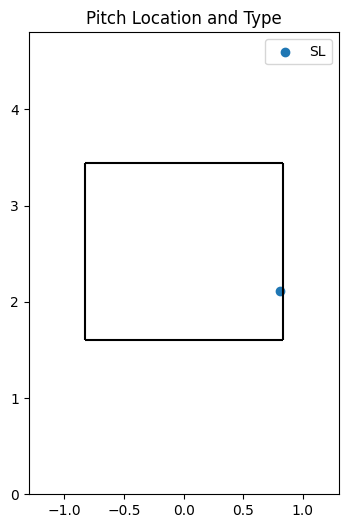

Result: single
Pitcher 656629 v Batter 657757
  Outs: 1
  Count: 0-0
  Runners: {1: True, 2: True, 3: False}
  Runs: 0
Enter the pitch you would like to throw (CB, CH, FF, SL): CB
Enter the x coordinate of this pitch: 0
Enter the z coordinate of this pitch: 2


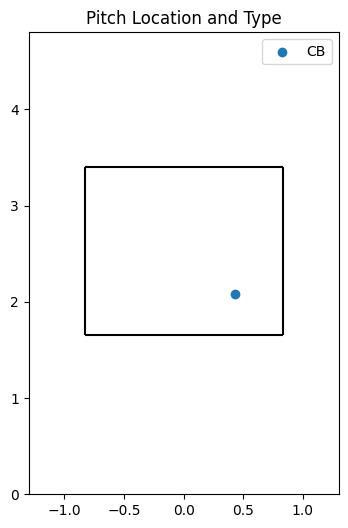

Result: strike
Pitcher 656629 v Batter 657757
  Outs: 1
  Count: 0-1
  Runners: {1: True, 2: True, 3: False}
  Runs: 0
Enter the pitch you would like to throw (CB, CH, FF, SL): FF
Enter the x coordinate of this pitch: -.5
Enter the z coordinate of this pitch: 3.5


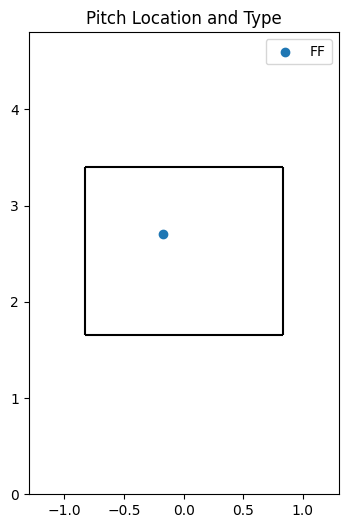

Result: foul
Pitcher 656629 v Batter 657757
  Outs: 1
  Count: 0-2
  Runners: {1: True, 2: True, 3: False}
  Runs: 0
Enter the pitch you would like to throw (CB, CH, FF, SL): CH
Enter the x coordinate of this pitch: -.8
Enter the z coordinate of this pitch: 1.6


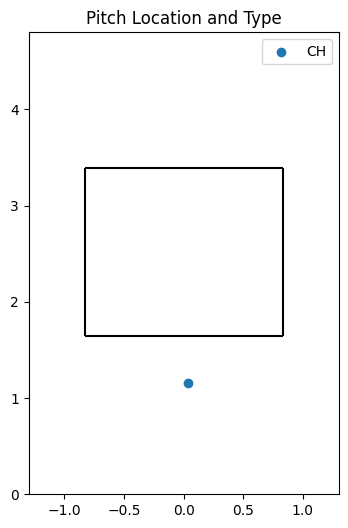

Result: ball
Pitcher 656629 v Batter 657757
  Outs: 1
  Count: 1-2
  Runners: {1: True, 2: True, 3: False}
  Runs: 0
Enter the pitch you would like to throw (CB, CH, FF, SL): FF
Enter the x coordinate of this pitch: 0
Enter the z coordinate of this pitch: 3.6


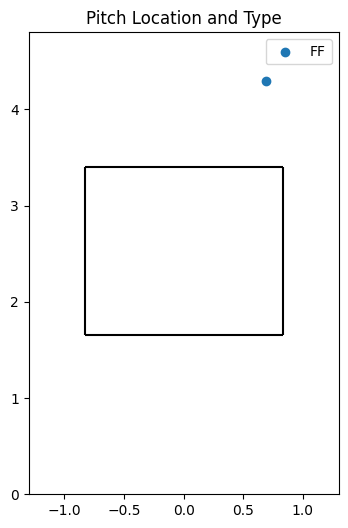

Result: ball
Pitcher 656629 v Batter 657757
  Outs: 1
  Count: 2-2
  Runners: {1: True, 2: True, 3: False}
  Runs: 0
Enter the pitch you would like to throw (CB, CH, FF, SL): 0
Invalid pitch type.
Enter the pitch you would like to throw (CB, CH, FF, SL): FF
Enter the x coordinate of this pitch: 0
Enter the z coordinate of this pitch: 3.2


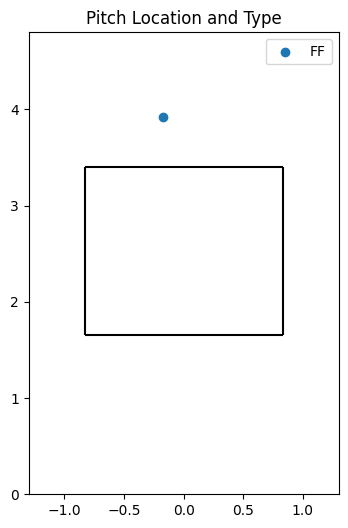

Result: strike
Pitcher 656629 v Batter 571912
  Outs: 2
  Count: 0-0
  Runners: {1: True, 2: True, 3: False}
  Runs: 0
Enter the pitch you would like to throw (CB, CH, FF, SL): CB
Enter the x coordinate of this pitch: 0
Enter the z coordinate of this pitch: 1.7


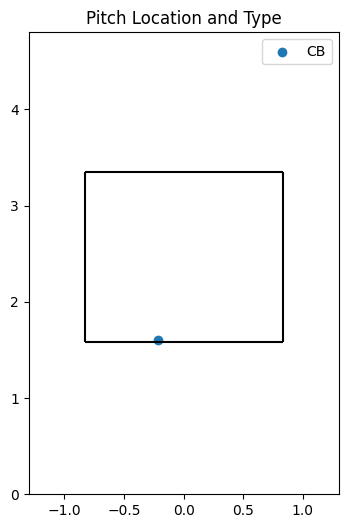

Result: strike
Pitcher 656629 v Batter 571912
  Outs: 2
  Count: 0-1
  Runners: {1: True, 2: True, 3: False}
  Runs: 0
Enter the pitch you would like to throw (CB, CH, FF, SL): CB
Enter the x coordinate of this pitch: 0.5
Enter the z coordinate of this pitch: 2


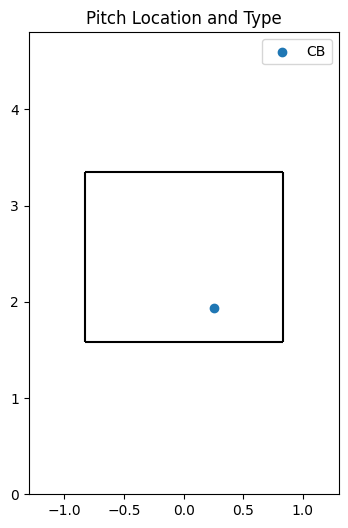

Result: single
Pitcher 656629 v Batter 657656
  Outs: 2
  Count: 0-0
  Runners: {1: True, 2: True, 3: True}
  Runs: 0
Enter the pitch you would like to throw (CB, CH, FF, SL): FF
Enter the x coordinate of this pitch: 0
Enter the z coordinate of this pitch: 2


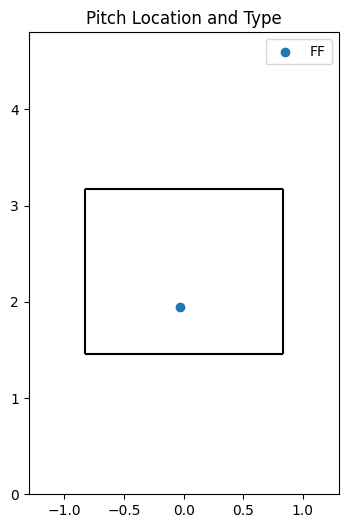

Result: foul
Pitcher 656629 v Batter 657656
  Outs: 2
  Count: 0-1
  Runners: {1: True, 2: True, 3: True}
  Runs: 0
Enter the pitch you would like to throw (CB, CH, FF, SL): FF
Enter the x coordinate of this pitch: 0.2
Enter the z coordinate of this pitch: 3


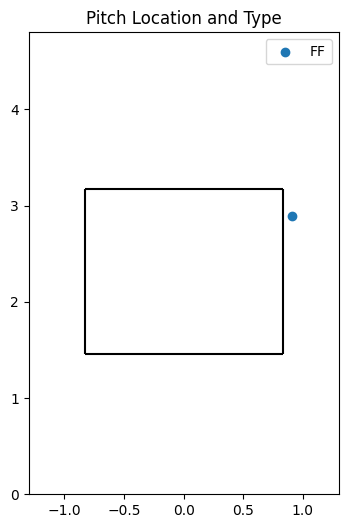

Result: ball
Pitcher 656629 v Batter 657656
  Outs: 2
  Count: 1-1
  Runners: {1: True, 2: True, 3: True}
  Runs: 0
Enter the pitch you would like to throw (CB, CH, FF, SL): 0.5
Invalid pitch type.
Enter the pitch you would like to throw (CB, CH, FF, SL): SL
Enter the x coordinate of this pitch: -0.5
Enter the z coordinate of this pitch: 2


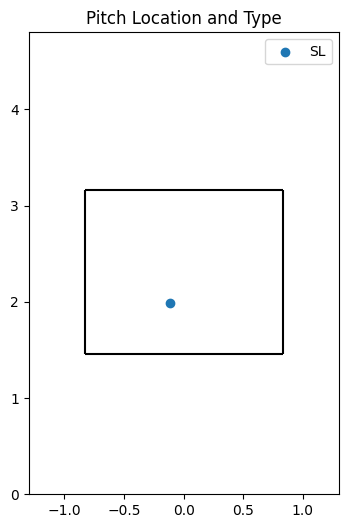

Result: single
Pitcher 656629 v Batter 592450
  Outs: 2
  Count: 0-0
  Runners: {1: True, 2: True, 3: True}
  Runs: 1
Enter the pitch you would like to throw (CB, CH, FF, SL): CH
Enter the x coordinate of this pitch: 0.5
Enter the z coordinate of this pitch: 2


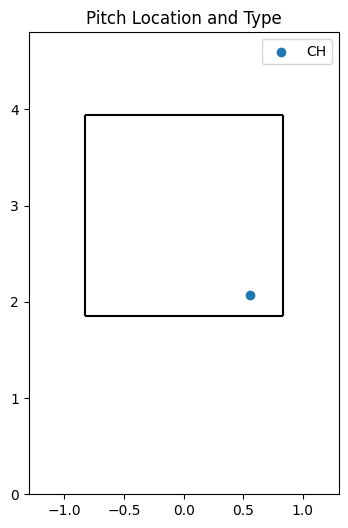

Result: strike
Pitcher 656629 v Batter 592450
  Outs: 2
  Count: 0-1
  Runners: {1: True, 2: True, 3: True}
  Runs: 1
Enter the pitch you would like to throw (CB, CH, FF, SL): FF
Enter the x coordinate of this pitch: -.8
Enter the z coordinate of this pitch: 2


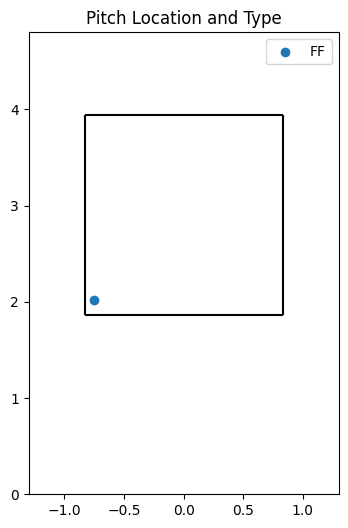

Result: foul
Pitcher 656629 v Batter 592450
  Outs: 2
  Count: 0-2
  Runners: {1: True, 2: True, 3: True}
  Runs: 1
Enter the pitch you would like to throw (CB, CH, FF, SL): -.8
Invalid pitch type.
Enter the pitch you would like to throw (CB, CH, FF, SL): SL
Enter the x coordinate of this pitch: -.8
Enter the z coordinate of this pitch: 3


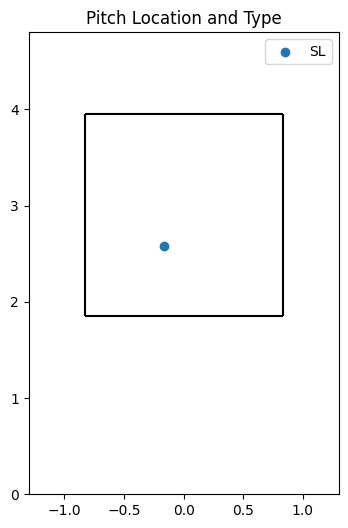

Result: foul
Pitcher 656629 v Batter 592450
  Outs: 2
  Count: 0-2
  Runners: {1: True, 2: True, 3: True}
  Runs: 1
Enter the pitch you would like to throw (CB, CH, FF, SL): CH
Enter the x coordinate of this pitch: 0.7
Enter the z coordinate of this pitch: 2


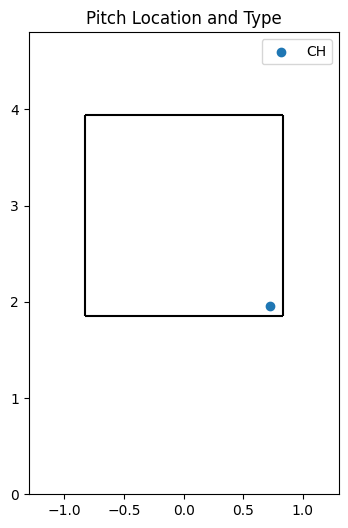

Result: out
INNING OVER






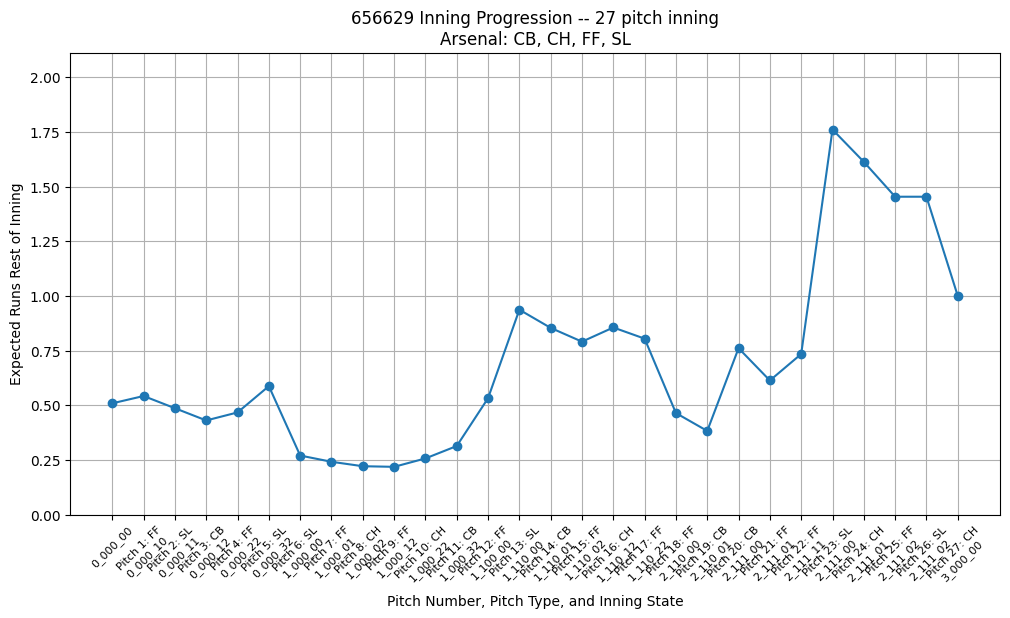

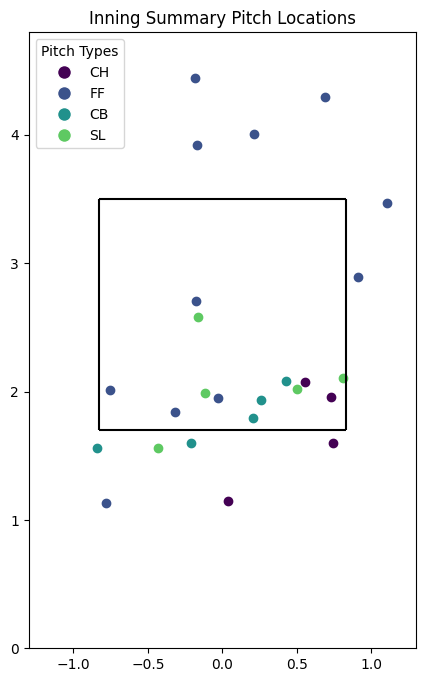

In [35]:
# Randomly select a pitcher and 9 batters from their respective dictionaries
pitcher = random.sample(list(pitcher_dict.keys()), 1)[0]
batters = random.sample(list(batter_dict.keys()), 9)
batters_str = ', '.join(str(num) for num in batters)  # Convert batter IDs to a string

# Retrieve the pitching hand and types of pitches this pitcher can throw
pitcher_hand = list(pitcher_dict[pitcher].keys())[0]
pitch_types = list(pitcher_dict[pitcher][pitcher_hand].keys())
pitch_types_str = ', '.join(pitch_types)  # Convert pitch types to a string for display
pitch_types_dict = pitcher_dict[pitcher][pitcher_hand]  # Dictionary with pitcher's pitch type stats

# Define dimensions of the strike zone's sides
sz_left = -9.97/12
sz_right = 9.97/12
sz_side_mid = (sz_left + sz_right) / 2  # Middle of the strike zone sides
sz_side_third = abs(sz_left - sz_right) / 3  # One third of the strike zone's width

# Calculate positions for potential pitch locations horizontally across the strike zone
sz_side_locs = [sz_side_mid - 2*sz_side_third,
                sz_side_mid - sz_side_third,
                sz_side_mid,
                sz_side_mid + sz_side_third,
                sz_side_mid + 2*sz_side_third]

# Standard deviations for random variations in pitch locations
x_miss_sd = 0.4  # Standard deviation for horizontal miss
z_miss_sd = 0.4  # Standard deviation for vertical miss

# Print information about the selected pitcher and batters
print(f'Pitcher: {pitcher} ({pitcher_hand})\nPitches: {pitch_types}')
print(f"Batters: {batters_str}\n")
print(f'The strikezone typically spans from (-0.9, 0.9) left to right and (1.7, 3.5) bottom to top\n\n')

# Initialize the game state with the selected batters and pitcher
game_state = GameState(batting_order=batters, pitcher=pitcher)

# Initialize tracking variables for the game state, run values, pitches, and pitch locations
states = [game_state.to_code()]
rvs = [re288[game_state.to_code()]]
pitches = [None]
xs = [None]
zs = [None]

# Loop to simulate the game until there are 3 outs
while game_state.outs < 3:
    cur_state = game_state.copy()  # Copy the current game state

    # Get the current batter
    batter = game_state.batting_order[game_state.current_batter_index]

    # Input loop for the user to select the pitch type
    pitch = False
    while pitch not in pitch_types:
        pitch = input(f'Enter the pitch you would like to throw ({pitch_types_str}): ')
        if pitch not in pitch_types:
            print('Invalid pitch type.')

    # Input loop for the user to enter the x coordinate of the pitch
    while True:
        loc_x = input(f'Enter the x coordinate of this pitch: ')
        try:
            loc_x = float(loc_x)
            break
        except:
            print("Invalid input.")

    # Input loop for the user to enter the z coordinate of the pitch
    while True:
        loc_z = input(f'Enter the z coordinate of this pitch: ')
        try:
            loc_z = float(loc_z)
            break
        except:
            print("Invalid input.")

    # Generate a prediction dictionary with the selected pitch and its location
    prediction_dictionary = generate_prediction_dictionary(pitcher_hand, batter, pitch, cur_state, pitch_types_dict)

    # Adjust pitch location to account for random variation
    prediction_dictionary['plate_x'] = np.random.normal(loc_x, x_miss_sd)
    prediction_dictionary['plate_z'] = np.random.normal(loc_z, z_miss_sd)

    xs.append(prediction_dictionary['plate_x'])
    zs.append(prediction_dictionary['plate_z'])

    # Simulate the outcome of the pitch
    event = simulate_action(prediction_dictionary)

    # Update the game state based on the event
    game_state = game_state.update_state(event)

    # Handle the end of the inning
    if game_state.outs == 3:
        states.append('3_000_00')
        rvs.append(game_state.runs)
        pitches.append(pitch)
        plot_result(prediction_dictionary, pitch, prediction_dictionary['sz_bot'], prediction_dictionary['sz_top'], sz_left, sz_right, event, game_state)
        continue

    states.append(game_state.to_code())
    rvs.append(re288[game_state.to_code()] + game_state.runs)
    pitches.append(pitch)
    plot_result(prediction_dictionary, pitch, prediction_dictionary['sz_bot'], prediction_dictionary['sz_top'], sz_left, sz_right, event, game_state)

# Plot a summary of the inning after all pitches
plot_inning(states, rvs, pitches, xs, zs, pitch_types)
